In [32]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.optim as optim
import matplotlib.pyplot as plt

In [6]:
train_data = datasets.MNIST(root = 'data' ,train='True' , download=True,transform = ToTensor())
test_data = datasets.MNIST(root = 'data', train='False' , download=True,transform = ToTensor())


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 75.2MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 24.2MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found




100%|██████████| 1.65M/1.65M [00:00<00:00, 83.3MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.27MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [33]:
len(train_data),len(test_data)


(60000, 60000)

In [34]:
class_names = train_data.classes
print(class_names)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [35]:
image,label = train_data[0]     # selecting the first sample of training data
image.shape,label

(torch.Size([1, 28, 28]), 5)

Text(0.5, 1.0, '5')

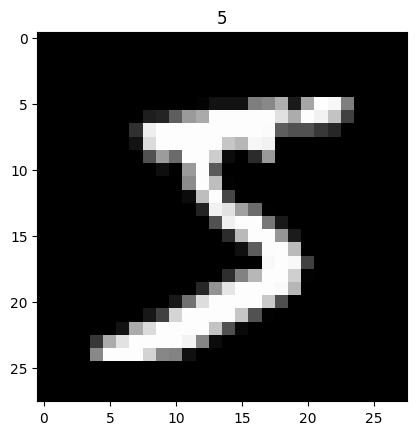

In [36]:
plt.imshow(image.squeeze(),cmap = 'gray')
plt.title(label)

In [41]:
class MNIST_Model(nn.Module) :
  def __init__(self,activation) :
    super(MNIST_Model,self).__init__()

    self.fc1 = nn.Linear(in_features = 784 , out_features = 64)
    self.fc2 = nn.Linear(in_features = 64 , out_features = 32)
    self.fc3 = nn.Linear(in_features = 32 , out_features = 10)
    self.activation = activation

  def forward(self,x) :
    x = x.view(-1,784)
    x = self.activation(self.fc1(x))
    x = self.activation(self.fc2(x))
    x = self.fc3(x)
    return x



In [38]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [45]:
import time

In [46]:
def train_and_evaluate(activation_fn, activation_name):
    model = MNIST_Model(activation_fn).to("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    start_time = time.time()

    for epoch in range(3):
        model.train()
        epoch_start = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Check gradient norms (for vanishing/exploding gradient detection)
            total_norm = 0
            for param in model.parameters():
                if param.grad is not None:
                    total_norm += param.grad.norm().item()

            optimizer.step()

        epoch_time = time.time() - epoch_start

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Activation: {activation_name}, Epoch: {epoch+1}, Accuracy: {accuracy:.2f}%, Gradient Norm: {total_norm:.4f}, Time: {epoch_time:.2f}s")

    total_time = time.time() - start_time
    print(f"✅ {activation_name}: Total Training Time = {total_time:.2f} seconds\n")

In [48]:
train_and_evaluate(nn.ReLU(), "ReLU")
train_and_evaluate(nn.LeakyReLU(0.01), "Leaky ReLU")
train_and_evaluate(nn.Sigmoid(), "Sigmoid")

Activation: ReLU, Epoch: 1, Accuracy: 93.56%, Gradient Norm: 1.7079, Time: 9.68s
Activation: ReLU, Epoch: 2, Accuracy: 95.75%, Gradient Norm: 1.3839, Time: 9.09s
Activation: ReLU, Epoch: 3, Accuracy: 96.66%, Gradient Norm: 2.2408, Time: 9.41s
✅ ReLU: Total Training Time = 50.02 seconds

Activation: Leaky ReLU, Epoch: 1, Accuracy: 93.11%, Gradient Norm: 3.0958, Time: 9.64s
Activation: Leaky ReLU, Epoch: 2, Accuracy: 95.82%, Gradient Norm: 0.6046, Time: 8.98s
Activation: Leaky ReLU, Epoch: 3, Accuracy: 96.66%, Gradient Norm: 2.7269, Time: 9.40s
✅ Leaky ReLU: Total Training Time = 50.12 seconds

Activation: Sigmoid, Epoch: 1, Accuracy: 90.13%, Gradient Norm: 0.7407, Time: 9.38s
Activation: Sigmoid, Epoch: 2, Accuracy: 93.61%, Gradient Norm: 0.5608, Time: 8.78s
Activation: Sigmoid, Epoch: 3, Accuracy: 95.06%, Gradient Norm: 0.8784, Time: 9.33s
✅ Sigmoid: Total Training Time = 49.11 seconds

